Assessment / Midterm: Machine Vision and Deep Learning
1) Answer all questions

2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc

3) Copy this notebook to your google drive (click FILE > save a copy in Drive)

4) Upload the answer notebook & trained model (for Question 3) to your github.

5) Submit the assessment by sharing the link to your github containing the answers.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**QUESTION 1 [15 marks]**

a) Let *k*, *s* and *p* be 4, 2 and 1, respectively. What will be the shape of the output of the convolutional layer? (2 marks)

>>import torch \
import torch.nn as nn \
input_img = torch.rand(1,3,10,10) \
layer = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=*k*, stride=*s*, padding=*p*)

<span style="color:blue">
    answer: The shape of the output is [1,12,5,5]
</span>

b) Batch Normalization (BN) normalizes the mean and standard deviation for each: (tick X for the correct answer) (2 marks)

 - [X] Individual feature map
 - [ ] Instance in the mini-batch
 - [ ] Spatial dimension    

c) Which one of the following is not an advantage of Batch Normalization (BN)? (tick X for the correct answer) (2 marks)

- [ ] BN accelerates the training of deep neural networks and tackles the vanishing gradient problem.
- [ ] For every input mini-batch, we calculate different statistics. This introduces some sort of regularization.
- [ ] BN reduces the dependence of gradients on the scale of the parameters or of their initial values.
- [X] BN needs a much slower learning rate for the total architecture to converge.

d) Choose the correct statement. (tick X for the correct answer) (2 marks)

- [ ] A larger kernel is preferred for information that resides globally, and a smaller kernel is preferred for information that is distributed locally.
- [X] A larger kernel is preferred for information that resides locally, and a smaller kernel is preferred for information that is distributed globally.

e) In the following network, how many learnable parameters (weights) are there? (2 marks)


model = nn.Sequential(
        nn.Linear(3,20),
        nn.ReLU(),
        nn.Linear(20,2)
    )

<span style="color:blue">
    answer: There are 100 learnable parameters.
</span>

f) Which of the following statements are true about deep neural networks? (tick X for the correct answer) (2 marks)

- [X] Deep neural networks usually require a big amount of data to be properly trained.
- [X] They can be fooled by adversarial/ noisy examples.
- [X] They are difficult to interpret and understand.
- [ ] They can still be subject to biases.
- [ ] They fail to understand the context of the data that they are handling.
- [ ] They perform very well on individual tasks but fail to generalize to many different tasks.

g) Run the code in the next cell. 

g) Run the code in the next cell. 

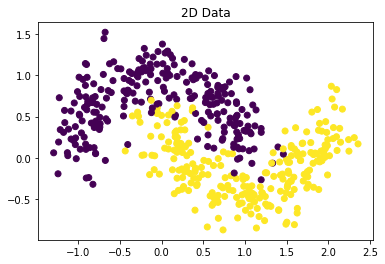

In [ ]:
# import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

# generate synthetic data in 2D
X, Y = make_moons(500, noise=0.2)

# plot the data
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title('2D Data')
plt.show()

Can this data be correctly separable using the classifier below? Why? (3 marks)

model = nn.Sequential( \
    nn.Linear(n_input_dim, n_output), \
    nn.Sigmoid() \
    )
    
<span style="color:blue">
    answer: Yes, because the data is separated by having 2 values where 1 pass as the output and another 1 not to pass as the output. 
</span>

**QUESTION 2 [50 marks]** 

The COVID-19 pandemic continues to have a devastating effect on the health and well-being of the global population. A critical step in the fight against COVID-19 is effective screening of infected patients, with one of the key screening approaches being radiology examination using chest radiography. As a deep learning engineer, you are tasked to classify a dataset of X-ray images as either "normal", "covid" or "viral pneumonia". Use the chest X-ray dataset publicly available at https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset to answer the following questions.


a) Train a feedforward neural network to solve the classification problem. Please include: **(10 marks)**

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) The training loop.

    4) Output the mean accuracy for the whole testing dataset.
    
    5) The hyperparameters are:
        i  - architecture: 2 hidden layers
        ii - input size  : 32x32 

In [ ]:
###############################################
###############YOUR CODES HERE ################
###############################################
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

transform = transforms.Compose(
    [
    transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the Data

# Set train and valid directory paths
dataset = '/content/drive/MyDrive/Covid19DataSet'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'test')

# Batch size
batchSize = 8

# Number of classes
num_classes = len(os.listdir(train_directory))
print("number class available: "+ str(num_classes))

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=transform),

    'test': datasets.ImageFolder(root=test_directory, transform=transform)
}
classes = ('Covid', 'Normal', 'Viral_Pneumonia')


number class available: 3


In [ ]:
# 1) dataloader
train_data_size = len(data['train'])
test_data_size = len(data['test'])

trainloader = torch.utils.data.DataLoader(data['train'], batch_size=batchSize,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(data['test'], batch_size=batchSize,
                                          shuffle=True)

In [ ]:
# 2) model definition
class myModel(nn.Module): 
    def __init__(self): 
        super(myModel, self).__init__() 
        self.linear1 = nn.Linear(3072, 128) 
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 3) 
        self.relu = nn.ReLU()
  
    def forward(self, x): 
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        o = self.linear3(x)

        return o 
    
model = myModel()

In [ ]:
# 3) Training loop

# LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            #reshape images so they can be fed to a nn.Linear()
            inputs = inputs.view(inputs.size(0), -1)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                #reshape images so they can be fed to a nn.Linear()
                inputs = inputs.view(inputs.size(0), -1)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.5002, Accuracy: 80.0797%, 
		Validation : Loss : 0.5597, Accuracy: 80.3030%, Time: 142.7552s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.2578, Accuracy: 92.0319%, 
		Validation : Loss : 0.4250, Accuracy: 86.3636%, Time: 13.5074s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.1726, Accuracy: 94.0239%, 
		Validation : Loss : 0.4403, Accuracy: 83.3333%, Time: 14.7790s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.1483, Accuracy: 94.8207%, 
		Validation : Loss : 0.4088, Accuracy: 87.8788%, Time: 13.4862s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.1030, Accuracy: 95.6175%, 
		Validation : Loss : 0.4084, Accuracy: 87.8788%, Time: 13.6709s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.0780, Accuracy: 96.4143%, 
		Validation : Loss : 0.3991, Accuracy: 86.3636%, Time: 13.6770s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.0306, Accuracy: 99.6016%, 
		Validation : Loss : 0.3552, Accuracy: 90.9091%, Time: 13.5009s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.0118, Accur

In [ ]:
# 4) Output the mean accuracy for the whole testing dataset.

correct = 0
total = 0

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predicted):
          if label == prediction:
            correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the test images: 90 %
Accuracy for class: Covid is 92.3 %
Accuracy for class: Normal is 80.0 %
Accuracy for class: Viral_Pneumonia is 100.0 %


b) Create and train a ConvNet corresponding to the following architecture in Fig. 1 (with modifications of the input and final layers). Please include **(10 marks)**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/LeNet.png)
    
                                Fig. 1: A convolutional neural network

In [ ]:
###############################################
###############YOUR CODES HERE ################
###############################################
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

transform = transforms.Compose(
    [
    transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the Data

# Set train and valid directory paths
dataset = '/content/drive/MyDrive/Covid19DataSet'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'test')

# Batch size
batchSize = 8

# Number of classes
num_classes = len(os.listdir(train_directory))
print("number class available: "+ str(num_classes))

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=transform),

    'test': datasets.ImageFolder(root=test_directory, transform=transform)
}

number class available: 3


In [ ]:
# 1) dataloader
train_data_size = len(data['train'])
test_data_size = len(data['test'])

trainloader = torch.utils.data.DataLoader(data['train'], batch_size=batchSize,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(data['test'], batch_size=batchSize,
                                          shuffle=True)

In [ ]:
# 2) model definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 5*5*16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = CNN()

In [ ]:
# 3) Training loop

# LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

    
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.8774, Accuracy: 58.9641%, 
		Validation : Loss : 0.5871, Accuracy: 66.6667%, Time: 17.9682s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.3931, Accuracy: 84.8606%, 
		Validation : Loss : 0.5173, Accuracy: 81.8182%, Time: 13.6149s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2745, Accuracy: 89.2430%, 
		Validation : Loss : 0.4306, Accuracy: 80.3030%, Time: 13.7277s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2845, Accuracy: 87.6494%, 
		Validation : Loss : 0.5866, Accuracy: 75.7576%, Time: 13.8241s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2256, Accuracy: 92.8287%, 
		Validation : Loss : 0.4193, Accuracy: 83.3333%, Time: 13.7233s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1854, Accuracy: 92.8287%, 
		Validation : Loss : 0.4664, Accuracy: 80.3030%, Time: 13.6098s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.1916, Accuracy: 92.4303%, 
		Validation : Loss : 0.3890, Accuracy: 86.3636%, Time: 13.6671s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1635, Accura

In [ ]:
# 4) Output the mean accuracy for the whole testing dataset.

correct = 0
total = 0

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predicted):
          if label == prediction:
            correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the test images: 81 %
Accuracy for class: Covid is 88.5 %
Accuracy for class: Normal is 65.0 %
Accuracy for class: Viral_Pneumonia is 90.0 %


In [ ]:
correct = 0
total = 0

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predicted):
          if label == prediction:
            correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the train images: 96 %
Accuracy for class: Covid is 99.1 %
Accuracy for class: Normal is 90.0 %
Accuracy for class: Viral_Pneumonia is 98.6 %


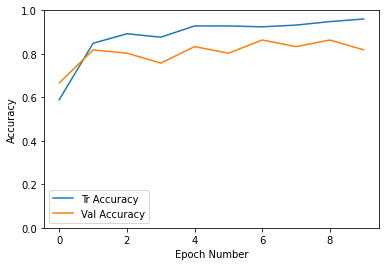

In [ ]:
# Output
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

c) Based on Question 2 b), answer the following questions: 
    
    i) Is the model overfitting? Why? (4 marks)
      <font color='blue'>YES. Because the accuracy of train and validation dataset has a gap of 10%</font>
    
    ii) Propose two methods to reduce the effect of overfitting. (4 marks)
   <font color='blue'>Two methods that I propose are: (1) data augmentation (2)using dropout and batch normalization</font>
   
    iii) Implement the two proposed methods in Q2 c) ii) in the next cell and show that the overfitting has been reduced. (8 marks)

In [ ]:
###############################################
###############YOUR CODES HERE ################
###############################################
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

transforms = {
    'train': transforms.Compose([
        transforms.Resize((32,32)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data

# Set train and valid directory paths
dataset = '/content/drive/MyDrive/Covid19DataSet'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'test')

# Batch size
batchSize = 8

# Number of classes
num_classes = len(os.listdir(train_directory))
print("number class available: "+ str(num_classes))

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=transforms['valid'])
}



number class available: 3


In [ ]:
# 1) dataloader
train_data_size = len(data['train'])
test_data_size = len(data['test'])

trainloader = torch.utils.data.DataLoader(data['train'], batch_size=batchSize,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(data['test'], batch_size=batchSize,
                                          shuffle=True)

In [ ]:
# 2) model definition
class CNNImproved(nn.Module):
    def __init__(self):
        super(CNNImproved, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 3)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(6)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.batchnorm(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 5*5*16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = CNNImproved()

In [ ]:
# 3) Training loop

# LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.7165, Accuracy: 70.9163%, 
		Validation : Loss : 0.4782, Accuracy: 78.7879%, Time: 15.4374s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.3234, Accuracy: 86.8526%, 
		Validation : Loss : 0.4349, Accuracy: 78.7879%, Time: 13.8150s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2751, Accuracy: 88.8446%, 
		Validation : Loss : 0.3821, Accuracy: 80.3030%, Time: 13.6412s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2258, Accuracy: 90.4382%, 
		Validation : Loss : 0.3588, Accuracy: 81.8182%, Time: 13.4538s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2191, Accuracy: 91.6335%, 
		Validation : Loss : 0.3820, Accuracy: 81.8182%, Time: 13.7292s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2076, Accuracy: 92.8287%, 
		Validation : Loss : 0.4141, Accuracy: 78.7879%, Time: 13.6153s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.1924, Accuracy: 92.8287%, 
		Validation : Loss : 0.2778, Accuracy: 90.9091%, Time: 13.7316s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1598, Accura

In [ ]:
# 4) Output the mean accuracy for the whole testing dataset.

correct = 0
total = 0

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predicted):
          if label == prediction:
            correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the test images: 87 %
Accuracy for class: Covid is 96.2 %
Accuracy for class: Normal is 85.0 %
Accuracy for class: Viral_Pneumonia is 80.0 %


In [ ]:
correct = 0
total = 0

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predicted):
          if label == prediction:
            correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the train images: 90 %
Accuracy for class: Covid is 100.0 %
Accuracy for class: Normal is 72.9 %
Accuracy for class: Viral_Pneumonia is 91.4 %


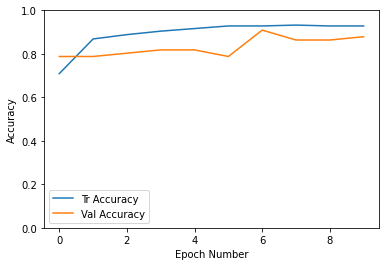

In [ ]:
# Output
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

d) Replace your defined ConvNet in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the COVID-19 dataset. **(10 marks)**

In [ ]:
###############################################
###############YOUR CODES HERE ################
###############################################
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

transforms = {
    'train': transforms.Compose([
        transforms.Resize((32,32)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data

# Set train and valid directory paths
dataset = '/content/drive/MyDrive/Covid19DataSet'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'test')

# Batch size
batchSize = 8

# Number of classes
num_classes = len(os.listdir(train_directory))
print("number class available: "+ str(num_classes))

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=transforms['valid'])
}

number class available: 3


In [ ]:
# 1) dataloader
train_data_size = len(data['train'])
test_data_size = len(data['test'])

trainloader = torch.utils.data.DataLoader(data['train'], batch_size=batchSize,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(data['test'], batch_size=batchSize,
                                          shuffle=True)

In [ ]:
# 2) model definition
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(in_features=1024, out_features=3, bias=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
# 3) Training loop

# LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, foreach=None)

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.1381, Accuracy: 33.0677%, 
		Validation : Loss : 1.1126, Accuracy: 34.8485%, Time: 15.4380s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.0934, Accuracy: 38.2470%, 
		Validation : Loss : 1.0301, Accuracy: 48.4848%, Time: 17.1977s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.0540, Accuracy: 46.2151%, 
		Validation : Loss : 1.0053, Accuracy: 43.9394%, Time: 15.1272s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.0145, Accuracy: 46.2151%, 
		Validation : Loss : 0.9493, Accuracy: 56.0606%, Time: 15.1328s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.9424, Accuracy: 58.5657%, 
		Validation : Loss : 0.9018, Accuracy: 59.0909%, Time: 16.2863s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.9103, Accuracy: 57.7689%, 
		Validation : Loss : 0.8983, Accuracy: 57.5758%, Time: 16.1267s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.8721, Accuracy: 68.5259%, 
		Validation : Loss : 0.7966, Accuracy: 66.6667%, Time: 15.1922s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.7944, Accura

In [ ]:
# 4) Output the mean accuracy for the whole testing dataset.

correct = 0
total = 0

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predicted):
          if label == prediction:
            correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the test images: 66 %
Accuracy for class: Covid is 84.6 %
Accuracy for class: Normal is 55.0 %
Accuracy for class: Viral_Pneumonia is 55.0 %


In [ ]:
correct = 0
total = 0

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predicted):
          if label == prediction:
            correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the train images: 77 %
Accuracy for class: Covid is 87.4 %
Accuracy for class: Normal is 71.4 %
Accuracy for class: Viral_Pneumonia is 68.6 %


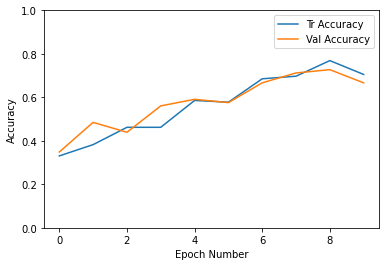

In [ ]:
# Output
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

e) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **(4 marks)**

<span style="color:blue">
    Yes. The improvement of the accuracy is contributed by the pretrained model and it is also due to the batch normalization, dropout and data augmentation. Moreover, the accuracy also can be improved by increasing the size of dataset to get more familiarize. Here, the overfitting issue will also be countered. </span>

**QUESTION 3** **[15 marks]**

In a machine vision project, you decide to design a door access control system based on hand gestures. Only those who shows the correct hand gesture will be granted the access. There are three gestures that are recognized as correct access passcode which are "shaka", "peace" and "thumbs up", as depicted in Fig. 2.

![pic](https://simplyorganizedhi.com/media/catalog/product/1/6/169500.jpg)

                                Fig. 2 Shaka,peace, and thumbs up


Using the end-to-end object detection pipeline that you have learned, develop your own hand gesture detector so that it can be incorporate to a door access control system.

Deliverables for this question are:

- the model file. Change the name to <your_name>.pt file (e.g. hasan.pt).

- 5 marks for plausible detection of each gesture.

In [ ]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 14474, done.
remote: Total 14474 (delta 0), reused 0 (delta 0), pack-reused 14474
Receiving objects: 100% (14474/14474), 13.62 MiB | 12.42 MiB/s, done.
Resolving deltas: 100% (9978/9978), done.
/content/yolov5
     |████████████████████████████████| 182 kB 25.7 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 1.6 MB 76.2 MB/s 
     |████████████████████████████████| 42 kB 820 kB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 178 kB 69.3 MB/s 
     |████████████████████████████████| 145 kB 74.0 MB/s 
     |████████████████████████████████| 138 kB 81.3 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
Setup complete. Using torch 1.13.0+cu116 (Tesla T4)


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="8Nf28czlvaFxTQJDX15g")
project = rf.workspace("school-hvqrt").project("hans-dhzvi")
dataset = project.version(2).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to hans-2 in yolov5pytorch:: 100%|██████████| 609/609 [00:00<00:00, 1310.07it/s]


In [ ]:
!python train.py --img 640 --batch 4 --epochs 100 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache --project /content/drive/MyDrive --name alwani

train: weights=yolov5s.pt, cfg=, data=/content/yolov5/hans-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/content/drive/MyDrive, name=alwani, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-32-g357cde9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, h

In [1]:
!python val.py --weights /content/drive/MyDrive/alwani/weights/alwani.pt --data {dataset.location}/data.yaml --img 640 --project /content/drive/MyDrive --name val_alwani

python3: can't open file 'val.py': [Errno 2] No such file or directory


In [ ]:
!python detect.py --img 800 --weights /content/drive/MyDrive/alwani/weights/alwani.pt --project /content/drive/MyDrive/yoloDetect --name peace_detect --source /content/drive/MyDrive/yoloDetect/peace.mp4


detect: weights=['/content/drive/MyDrive/alwani/weights/alwani.pt'], source=/content/drive/MyDrive/yoloDetect/peace.mp4, data=data/coco128.yaml, imgsz=[800, 800], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/yoloDetect, name=peace_detect, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-32-g357cde9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/53) /content/drive/MyDrive/yoloDetect/peace.mp4: 800x448 (no detections), 12.1ms
video 1/1 (2/53) /content/drive/MyDrive/yoloDetect/peace.mp4: 800x448 1 peace, 12.0ms
video 1/1 (3/53) /content/drive/MyDrive/yoloDetect/peace.mp4: 800x448 1 peace, 12.0ms
video 1/1

In [ ]:
!python detect.py --img 800 --weights /content/drive/MyDrive/alwani/weights/alwani.pt --project /content/drive/MyDrive/yoloDetect --name thumbs_detect --source /content/drive/MyDrive/yoloDetect/thumbs.mp4


detect: weights=['/content/drive/MyDrive/alwani/weights/alwani.pt'], source=/content/drive/MyDrive/yoloDetect/thumbs.mp4, data=data/coco128.yaml, imgsz=[800, 800], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/yoloDetect, name=thumbs_detect, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-32-g357cde9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/41) /content/drive/MyDrive/yoloDetect/thumbs.mp4: 800x448 1 thumbs, 12.1ms
video 1/1 (2/41) /content/drive/MyDrive/yoloDetect/thumbs.mp4: 800x448 1 thumbs, 11.9ms
video 1/1 (3/41) /content/drive/MyDrive/yoloDetect/thumbs.mp4: 800x448 1 shaka, 1 thumbs, 11.9ms


In [ ]:
!python detect.py --img 800 --weights /content/drive/MyDrive/alwani/weights/alwani.pt --project /content/drive/MyDrive/yoloDetect --name shaka_detect --source /content/drive/MyDrive/yoloDetect/shaka.mp4


detect: weights=['/content/drive/MyDrive/alwani/weights/alwani.pt'], source=/content/drive/MyDrive/yoloDetect/shaka.mp4, data=data/coco128.yaml, imgsz=[800, 800], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/yoloDetect, name=shaka_detect, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-32-g357cde9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/68) /content/drive/MyDrive/yoloDetect/shaka.mp4: 800x448 1 thumbs, 12.3ms
video 1/1 (2/68) /content/drive/MyDrive/yoloDetect/shaka.mp4: 800x448 1 thumbs, 12.1ms
video 1/1 (3/68) /content/drive/MyDrive/yoloDetect/shaka.mp4: 800x448 1 thumbs, 12.1ms
video 1/1 (4/6